# Lotsch BETSI

Adapted from the work of **J.W.M. Osterrieth**, **D. Fairen-Jimenez**, *et al.*: 
*How reproducible are surface areas calculated from the BET equation?*, DOI: [10.1002/adma.202201502](https://onlinelibrary.wiley.com/doi/full/10.1002/adma.202201502)


Written in October 2020 and revised in August 2022 by **Alexander M. Pütz** ([https://github.com/AlexanderPuetz](https://github.com/AlexanderPuetz)).
Develompent supported by the [Nanochemistry Department](https://www.fkf.mpg.de/lotsch) at the Max Planck Institute for Solid State Research, Stuttgart, Germany.


### Requirements

Please install [Python 3](https://www.python.org/) ([Anaconda](https://www.anaconda.com/products/individual) recommended) and [JupyterLab](https://jupyter.org/install). Satisfy all dependencies (see below). 
Run this notebook from a folder containing `./Data/` and `./Output/` subfolders. Place isotherm data as CSV file in `./Data/`. Partial example file:
```
"Relative Pressure","Volume @ STP"
9.84544e-06,0.3037
2.82767e-05,4.5413
4.51567e-05,6.6701
6.53845e-05,8.7974
...
```


## User variables

Below, please define the following: 
- `filename`: Filename (`*.csv`), must contain analyte (`N2`, `Ar`, or `CO2`, measured at 77 K, 87 K or 273 K, respectively)
- `data directory`: `./Data/` by default, but may be changed

- `min_set_length` and `min_r2`: Regression criteria which describe the quality of the linear fit

- `conditions`: List of conditions that need to be met by the BET fits (including [Roquerol criteria](https://www.sciencedirect.com/science/article/abs/pii/S0167299107800085))
    - `c_positive`: positive value of C constant (1st ...), 
    - `monotone`: monotonicity of the Roquerol plot over the fitting range (... and 2nd validity criterium). 
    - `within_BET_plot`: pressure of the monolayer loading must be within region of linear BET fit (1st...),
    - `pp_error`: error between partial pressures corresponding to monolayer loading from experiment and BET theory must be within percentage specified in `max_pp_error` (... and 2nd self-consistency criterium).
    - `r2_error`: minimum value for *R*<sup>2</sup> value of fit must be met
    - `knee_set`: fitted sets of data must inlclude knee point (see publication)

- `label_knee`: wether the knee point should be labeled in figures

In [249]:
filename = "P_Ar.csv"
directory = ".\Data\\"

min_set_length = 10 #(= 10) minimum number of points considered for a BET fit
min_r2 = 0.99 #(= 0.995) minimum quality of BET fit as described by R2

conditions = ['c_positive','monotone','within_BET_plot','pp_error','r2_error',] #possibilities: 'c_positive','monotone','within_BET_plot','pp_error','r2_error','knee_set'
max_pp_error = 20 #(= 20 %) maximum error between partial pressures of monolayer loading, 4th Rouquerol criterium


label_knee = True

### Calculations

*↓ scroll down for results ↓*

In [250]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
import seaborn as sns
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
from pandas import array
import pylab
import statsmodels.formula.api as sm
import warnings #suppress "FixedLocator" warnings when plotting
warnings.filterwarnings("ignore")

"""Read in and process isotherm data in the format 'relative pressure,quantity absorbed in cm3 g-1'"""
def process_data():
    global cross_section
    global data_full
    global data
    global data_interp
    global betplot_smooth
    global upper_limit

    """Read in gas info from filename and set cross sectional area in nm2 accordingly"""
    if 'N2' in filename: cross_section = 0.162 #at 77 K
    elif 'Ar' in filename: cross_section = 0.142 #at 87 K
    elif 'CO2' in filename: cross_section = 0.187 #at 273 K

    """Read in data from CSV file and remove desorption branch"""
    data_full = pd.read_csv(directory+filename, names=["relpress","quantity"], skiprows=1, engine='python') #import isotherm into pandas dataframe
    data = data_full.truncate(after=data_full["quantity"].idxmax()) #truncate analysis data to adsorption only
    data_full['type'] = 'Adsorption' #label data points
    data_full['type'].loc[data_full["quantity"].idxmax()+1:] = 'Desorption'

    """Convert data into amount absorbed in mmol g-1, Rouquerol and BET plot"""
    data["amountmol"] = data["quantity"]/22.4 #recalculate quantity (cm3 g-1) to amount (mmol g-1)
    data["rouquerol"] = data["amountmol"]*(1-data["relpress"]) #calculate Rouquerol plot n(1-p/p0) (mmol g-1)
    data["betplot"] = data["relpress"]/(data["amountmol"]/1000)/(1-data["relpress"]) #calculate BET plot (p/p0)/[n(1-p/p0)] (g mol-1)
    data_interp = interp1d(data['amountmol'], data['relpress'], kind='quadratic')

    upper_limit = data["rouquerol"].idxmax() #in case idmax value is still monotonically increasing
    for i in range(0, data["rouquerol"].idxmax()+1): #iterate through rouquerol plot and find knee, i.e., value up to which it increases monotonically with p/p0
        if data["rouquerol"][i]-data["rouquerol"][i+1] < 0: pass #continue search if next value is higher
        else: #stop search and save current value as knee if next value is smaller
            upper_limit = i
            break
    #print("Knee ID = "+str(upper_limit))

In [251]:
"""A Class which comprises attributes describing a set of isotherm data, its fit, and quantities calculated from it"""
class Isotherm_set:
    def __init__(self, start, end):
        self.start = start
        self.end = end
        self.viable = False
        self.corrupt = False
        self.conditions = dict.fromkeys(['monotone','c_positive','pp_error','r2_error','within_BET_plot','knee_set'] , 0)

    """Calculate OLS regression of the given data set"""
    def calculate_OLS_regression(self):
        try:
            ols_regression = sm.ols(formula="betplot ~ relpress", data=data.iloc[self.start:self.end+1]).fit()
            self.intercept = ols_regression.params.Intercept
            self.r2_error = ols_regression.rsquared
            self.slope = ols_regression.params.relpress
            self.c = 1+self.slope/self.intercept
            self.nm_bet = 1/(self.slope + self.intercept)*1000  #get monolayer amount according to BET plot (mmol g-1)
        except:
            print("OLS regression failed for "+self.start+"–"+self.end)
            self.corrupt = True

    """Calculate the BET area and related quantities from the linear fit parameters"""
    def calculate_BET_area(self):
        self.pp_bet = 1/(np.sqrt(self.c)+1) #get partial pressure at nm(BET)
        self.pp_exp = data_interp(self.nm_bet)[()] #get partial pressure of interpolated data for y = n_m(BET) = n_m(exp); [()] is needed to convert 0D ndarray to scalar float
        self.pp_error = abs((self.pp_bet-self.pp_exp))/self.pp_bet #get relative error
        self.area = self.nm_bet/1000*602214*cross_section #get BET area (m2 g-1)

    """Check if the Rouquerol criteria and others are satisfied"""
    def check_conditions(self): #perform a monotonicity check on each BET and discard those that are not
        self.check_monotonicity()
        if self.c > 1:                          self.conditions['c_positive'] = 1   #check if C constant is positive, 1st Rouquerol criterium
        if self.pp_error <= max_pp_error/100:   self.conditions['pp_error'] = 1     #check if p/p0(exp) does not deviate from p/p0(BET) by more than 20 %
        if self.r2_error >= min_r2:             self.conditions['r2_error'] = 1     #check if R2 is higher than given minimum
        if self.end == upper_limit:             self.conditions['knee_set'] = 1     #check if set includes knee as end point
        if data['relpress'][self.start] <= self.pp_exp <= data['relpress'][self.end]: self.conditions['within_BET_plot'] = 1 #check if n_m(exp) is within BET plot
    
    """Check monotonicity of Rouquerol plot"""
    def check_monotonicity(self):
        self.conditions['monotone'] = 1 #set to 1 first, because of how scan works
        for n in range(self.start, self.end): #iterate through BET plot and check monotonicity upwards
            if data["rouquerol"][n]-data["rouquerol"][n+1] < 0: pass #continue search if next value is higher 
            else:  #stop search and reject BET if next value is smaller
                self.conditions["monotone"] = 0
                break

    """Check viability of the fit, only if all required conditions are satisfied"""
    def check_viability(self):
        checklist = []
        for condition in conditions:
            checklist.append(self.conditions[condition]) #extract only the condition results which are required by user
        if np.prod(checklist) == 1: self.viable = True #if one or more conditions are not met (value = 0), the product will be 0 and the check is failed


"""Create a list of all sets of data where minimum length is given"""
def create_sets():
    global sets
    sets = []
    for i in range(0, upper_limit+1):
        for j in range(0, upper_limit+1): #iterate over all possibilities (up to knee point)
            if j-i > min_set_length-1: #check set length against minimum
                sets.append(Isotherm_set(i,j))

"""Iterate over all sets of data and perform fit, BET calculations and condition checks. Return best fit"""
def calculate_best_fit():
    viable_fits = []
    for set in sets:
        if set is not None: #Omit empty items 
            set.calculate_OLS_regression()
            set.calculate_BET_area()
            set.check_conditions()
            set.check_viability()
            if set.viable: viable_fits.append(set)

    viable_pp_errors = []
    for fit in viable_fits: viable_pp_errors.append(fit.pp_error) #extract pp_errors of viable fits into new list
    return viable_fits, next((fit for fit in viable_fits if fit.pp_error == min(viable_pp_errors)), None) #return list of viable fits and fit, where pp_error is smallest
        

In [252]:
"""Label all lines in dataframe accoring to type of data point"""
def label_data():
    global data
    global data_appended
    global error_plot

    #construct dataframe for error plot
    area_list, pp_error_list, i_list, j_list = [],[],[],[]
    for fit in viable_fits:
        area_list.append(fit.area)
        pp_error_list.append(fit.pp_error * 100) #convert error values to % 
        i_list.append(fit.start)
        j_list.append(fit.end)
    error_plot = pd.DataFrame(area_list, columns =['area'])
    error_plot['error_percent'] = pp_error_list
    error_plot['i'] = i_list
    error_plot['j'] = j_list
    error_plot['type'] = 'All results'
    if label_knee: error_plot['type'].loc[error_plot['j'] == upper_limit] = 'Knee set'
    error_plot['type'].loc[error_plot['error_percent']/100 == best_fit.pp_error] = 'Best result'

    #assign type labels to isotherm dataframe
    data['type'] = 'Absorption isotherm'
    data['type'].iloc[best_fit.start:best_fit.end] = 'Linear BET range'
    if label_knee: data['type'].iloc[upper_limit] = 'Knee'

    #append nm(read) and nm(BET) to data for plotting
    nm_data = {'relpress': [best_fit.pp_bet, best_fit.pp_exp], 
               'quantity': [best_fit.nm_bet*22.4, best_fit.nm_bet*22.4],
               'amountmol' : [best_fit.nm_bet, best_fit.nm_bet],
               'rouquerol' : [np.NaN,np.NaN],
               'betplot' : [np.NaN,np.NaN],
               'type' :['nm(BET)','nm(exp)']
              }
    data_appended = pd.concat([data, pd.DataFrame(data = nm_data)])

    
"""Create, print, and save report"""
def create_report(): #create report 
    global savename
    if 'knee_set' in conditions: savename = ".\Output\\"+filename[:-4]+"_knee" #construct savename
    else: savename = ".\Output\\"+filename[:-4]
    data_appended.to_csv(savename+".csv",index=False) #save labelled data

    #write out summary text
    summary_title = "Analysis results for "+filename
    title_length = 10 + len(summary_title)
    summary = title_length*'='
    summary += '\n'+5*' '+summary_title+5*' '
    summary += '\n'+title_length*'='
    summary += '\n'+'  Fitting set    '+str(best_fit.start)+'..'+str(best_fit.end)
    summary += '\n'+'  Fitting range  '+str(data['relpress'][best_fit.start])+'...'+str(data['relpress'][best_fit.end])
    summary += '\n'+'  Slope          '+"{:.2f}".format(best_fit.slope)+' g mmol-1'
    summary += '\n'+'  Intercept      '+"{:.2f}".format(best_fit.intercept)+' g mmol-1'
    summary += '\n'+'  R2             '+"{:.6f}".format(best_fit.r2_error)+'\n'
    summary += '\n'+'  as(BET)    '+"{:.2f}".format(best_fit.area)+' m2g-1'
    summary += '\n'+'  C          '+"{:.2f}".format(best_fit.c)
    summary += '\n'+'  nm(BET)    '+"{:.2f}".format(best_fit.nm_bet)+' mmol g-1'
    summary += '\n'+'  p/p0(BET)  '+"{:.6f}".format(best_fit.pp_bet)
    summary += '\n'+'  p/p0(exp)  '+"{:.6f}".format(best_fit.pp_exp)
    summary += '\n'+'  Rel. error '+"{:.2f} %".format(100*best_fit.pp_error)
    
    # save results to TXT file and print
    with open(savename+".txt","w") as file: file.write(summary)
    print(summary)
    
"""Create, show, and save overview figure"""
def create_figure():
    colors = ['#5C6F92','#E98F4C','#91354B','#CFCFCF','#12316A','#8EA5B8','#C8697F']
    pal = sns.color_palette(palette=colors, n_colors=len(colors))
    sns.set_theme(style="ticks", font_scale=0.25)
    sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
    sns.set_palette(pal)
    linewidth = 0.6
    ticklength = 3
    fontsize = 6
    
    def set_figure(fig): #define some basic parameters
        fig.tick_params('both', length=ticklength, width=linewidth, which='major')
        fig.tick_params('both', length=ticklength/2, width=linewidth, which='minor')
        fig.spines['top'].set_linewidth(linewidth)
        fig.spines['right'].set_linewidth(linewidth)
        fig.spines['bottom'].set_linewidth(linewidth)
        fig.spines['left'].set_linewidth(linewidth)
        lgnd = plt.legend(title=None, fontsize=fontsize, frameon=False)
        for lh in lgnd.legendHandles: 
            lh._sizes = [linewidth*10]
            lh.set_alpha(1)

    #plot isotherm overview
    plt.figure(figsize=(6.90,6.74), dpi= 300).subplots_adjust(hspace=0.4, wspace=0.3)
    plt.subplot(3, 3, 1)
    g1 = sns.scatterplot(
        data=data_full, x='relpress', y='quantity', 
        alpha=0.5,
        hue='type',
        edgecolor=None,
        linewidth=linewidth*0.67,
        s=linewidth*15
    )
    plt.xlabel(r"Equilibrium relative pressure $p/p^{0}$", fontsize=fontsize, labelpad = 2)
    plt.ylabel(r"Volume ads. at STP / cm$^{3}$ g$^{-1}$", fontsize=fontsize, labelpad = 2)
    plt.title('Isotherm', fontsize=fontsize, style='italic', pad = 2)
    #plt.xscale('log')
    set_figure(g1)
    g1.set_xticklabels(g1.get_xticks(), size = fontsize)
    g1.set_yticklabels(g1.get_yticks(), size = fontsize)
    g1.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    g1.xaxis.set_major_formatter(ticker.ScalarFormatter())
    
    #plot Rouquerol representation
    plt.subplot(3, 3, 2)
    g2 = sns.scatterplot(
        data=data, x='relpress', y='rouquerol', 
        alpha=0.5,
        hue='type',
        edgecolor=None,
        linewidth=linewidth*0.67,
        s=linewidth*15
    )
    plt.xlabel(r"Equilibrium relative pressure $p/p^{0}$", fontsize=fontsize, labelpad = 2)
    plt.ylabel(r"$n^{a}(1-p/p^{0})$ / mmol g$^{-1}$", fontsize=fontsize, labelpad = 2)
    plt.title('Rouquerol representation', fontsize=fontsize, style='italic', pad = 2)
    set_figure(g2)
    g2.set_xticklabels(g2.get_xticks(), size = fontsize)
    g2.set_yticklabels(g2.get_yticks(), size = fontsize)
    g2.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    g2.xaxis.set_major_formatter(ticker.ScalarFormatter())

    #plot BET plot
    plt.subplot(3, 3, 3)
    g3 = sns.scatterplot(
        data=data.iloc[0:upper_limit+1], x='relpress', y='betplot', 
        alpha=0.5,
        hue='type',
        edgecolor=None,
        linewidth=linewidth*0.67,
        s=linewidth*15
    )
    plt.xlabel(r"Equilibrium relative pressure $p/p^{0}$", fontsize=fontsize, labelpad = 2)
    plt.ylabel(r"$(p/p^{0})/[n^{a}(1-p/p^{0})]$ / g mol$^{-1}$", fontsize=fontsize, labelpad = 2)
    plt.title('BET plot under 1$^{\mathrm{st}}$ Rouquerol crit.', fontsize=fontsize, style='italic', pad = 2)
    set_figure(g3)
    g3.set_xticklabels(g3.get_xticks(), size = fontsize)
    g3.set_yticklabels(g3.get_yticks(), size = fontsize)
    g3.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    g3.xaxis.set_major_formatter(ticker.ScalarFormatter())
   
    #plot adsorption isotherm with BET range and monolayer loadings (linear)
    plt.subplot(3, 3, 4)
    g4 = sns.scatterplot(
        data=data_appended, x='relpress', y='amountmol', 
        hue='type',
        alpha=0.5,
        edgecolor=None,
        linewidth=linewidth*0.67,
        s=linewidth*15
    )
    plt.xlabel(r"Equilibrium relative pressure $p/p^{0}$", fontsize=fontsize, labelpad = 2)
    plt.ylabel(r"Amount adsorbed $n^{a}}$ / mmol g$^{-1}$", fontsize=fontsize, labelpad = 2)
    plt.title('Linear ads. isotherm', fontsize=fontsize, style='italic', pad = 2)
    set_figure(g4)
    g4.set_xticklabels(g4.get_xticks(), size = fontsize)
    g4.set_yticklabels(g4.get_yticks(), size = fontsize)
    g4.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    g4.xaxis.set_major_formatter(ticker.ScalarFormatter())

    #plot adsorption isotherm with BET range and monolayer loadings (semi-log)
    plt.subplot(3, 3, 5)
    g5 = sns.scatterplot(
        data=data_appended, x='relpress', y='amountmol', 
        hue='type',
        alpha=0.5,
        edgecolor=None,
        linewidth=linewidth*0.67,
        s=linewidth*15
    )
    plt.xlabel(r"Equilibrium relative pressure $p/p^{0}$", fontsize=fontsize, labelpad = 2)
    plt.ylabel(r"Amount adsorbed $n^{a}}$ / mmol g$^{-1}$", fontsize=fontsize, labelpad = 2)
    plt.title('Semi-logarithmic ads. isotherm', fontsize=fontsize, style='italic', pad = 2)
    plt.xscale('log')
    set_figure(g5)
    g5.set_xticklabels(g5.get_xticks(), size = fontsize)
    g5.set_yticklabels(g5.get_yticks(), size = fontsize)

    #plot linear range of BET plot with fit
    plt.subplot(3, 3, 6)
    g6 = sns.scatterplot(
        data=data.iloc[best_fit.start:best_fit.end], x='relpress', y='betplot', 
        alpha=0.5,
        edgecolor=None,
        linewidth=linewidth*0.67,
        s=linewidth*15
    )
    plt.xlabel(r"Equilibrium relative pressure $p/p^{0}$", fontsize=fontsize, labelpad = 2)
    plt.ylabel(r"$(p/p^{0})/[n^{a}(1-p/p^{0})]$ / g mol$^{-1}$", fontsize=fontsize, labelpad = 2)
    plt.title('Linear range of BET plot', fontsize=fontsize, style='italic', pad = 2)
    set_figure(g6)
    #plots the BET plot
    fit_x = data['relpress'].iloc[best_fit.start:best_fit.end]
    fit_y = best_fit.slope*fit_x+best_fit.intercept
    plt.plot(fit_x, fit_y, color='b',linewidth=linewidth)
    #adds info into legend
    lgnd = plt.legend(title=None, loc='upper left', labels=['Linear fit', 'BET plot'], fontsize=fontsize, frameon=False)
    for lh in lgnd.legendHandles: 
        lh._sizes = [linewidth*10]
        lh.set_alpha(1)
    g6.set_xticklabels(g6.get_xticks(), size = fontsize)
    g6.set_yticklabels(g6.get_yticks(), size = fontsize)
    g6.xaxis.set_major_locator(ticker.MultipleLocator(0.05))
    g6.xaxis.set_major_formatter(ticker.ScalarFormatter())

    #plots comparison of viable results as relative error versus BET area
    plt.subplot(3, 3, (7,9))
    g7 = sns.scatterplot(
        data=error_plot, x='area', y='error_percent', 
        alpha=0.5,
        hue='type',
        edgecolor=None,
        linewidth=linewidth*0.67,
        s=linewidth*15
    )
    plt.xlabel(r"BET area $a_{s}$(BET) / m$^{2}$ g$^{-1}$", fontsize=fontsize, labelpad = 2)
    plt.ylabel(r"Relative Error / %", fontsize=fontsize, labelpad = 2)
    plt.title("Valid results represented as relative error between $p/p^{0}$ of $n_{m}$(BET) and $n_{m}$(exp) vs. BET area", fontsize=fontsize, style='italic', pad = 2)
    set_figure(g7)
    for line in range(0,error_plot.shape[0]):
         g7.text(error_plot.area[line]+0.01, error_plot.error_percent[line], 
         str(error_plot.i[line])+','+str(error_plot.j[line]), horizontalalignment='left', 
         size='x-small', color='black', weight='normal', fontsize=fontsize)    
    g7.set_xticklabels(g7.get_xticks(), size = fontsize)
    g7.set_yticklabels(g7.get_yticks(), size = fontsize)
    
    plt.subplots_adjust(wspace=0.5)

    #save out figures
    print(savename)
    plt.savefig(savename+".pdf")
    plt.savefig(savename+".svg")


In [253]:
"""Main method taking care of all calculations"""
def main():
    global viable_fits
    global best_fit
    process_data()
    create_sets()
    viable_fits, best_fit = calculate_best_fit()
    if best_fit == None: 
        print("No valid result found!\nIf enabled, consider removing knee-set requirement.\nTry relaxing R2, or maximum error between BET-derived and experimental p/p0 at monolayer loading. (Warning: 4th Rouquerol criterium!)")
    label_data()
main()

## Results

Please find the report and overview figure below. These (in TXT and PDF format) and a CSV containing all data for external plotting were saved in `./Output/`.

In [254]:
create_report()

     Analysis results for P_Ar.csv     
  Fitting set    6..23
  Fitting range  0.000408614...0.125692
  Slope          44.78 g mmol-1
  Intercept      0.58 g mmol-1
  R2             0.990624

  as(BET)    1885.17 m2g-1
  C          78.25
  nm(BET)    22.05 mmol g-1
  p/p0(BET)  0.101568
  p/p0(exp)  0.100799
  Rel. error 0.76 %


No handles with labels found to put in legend.


.\Output\P_Ar


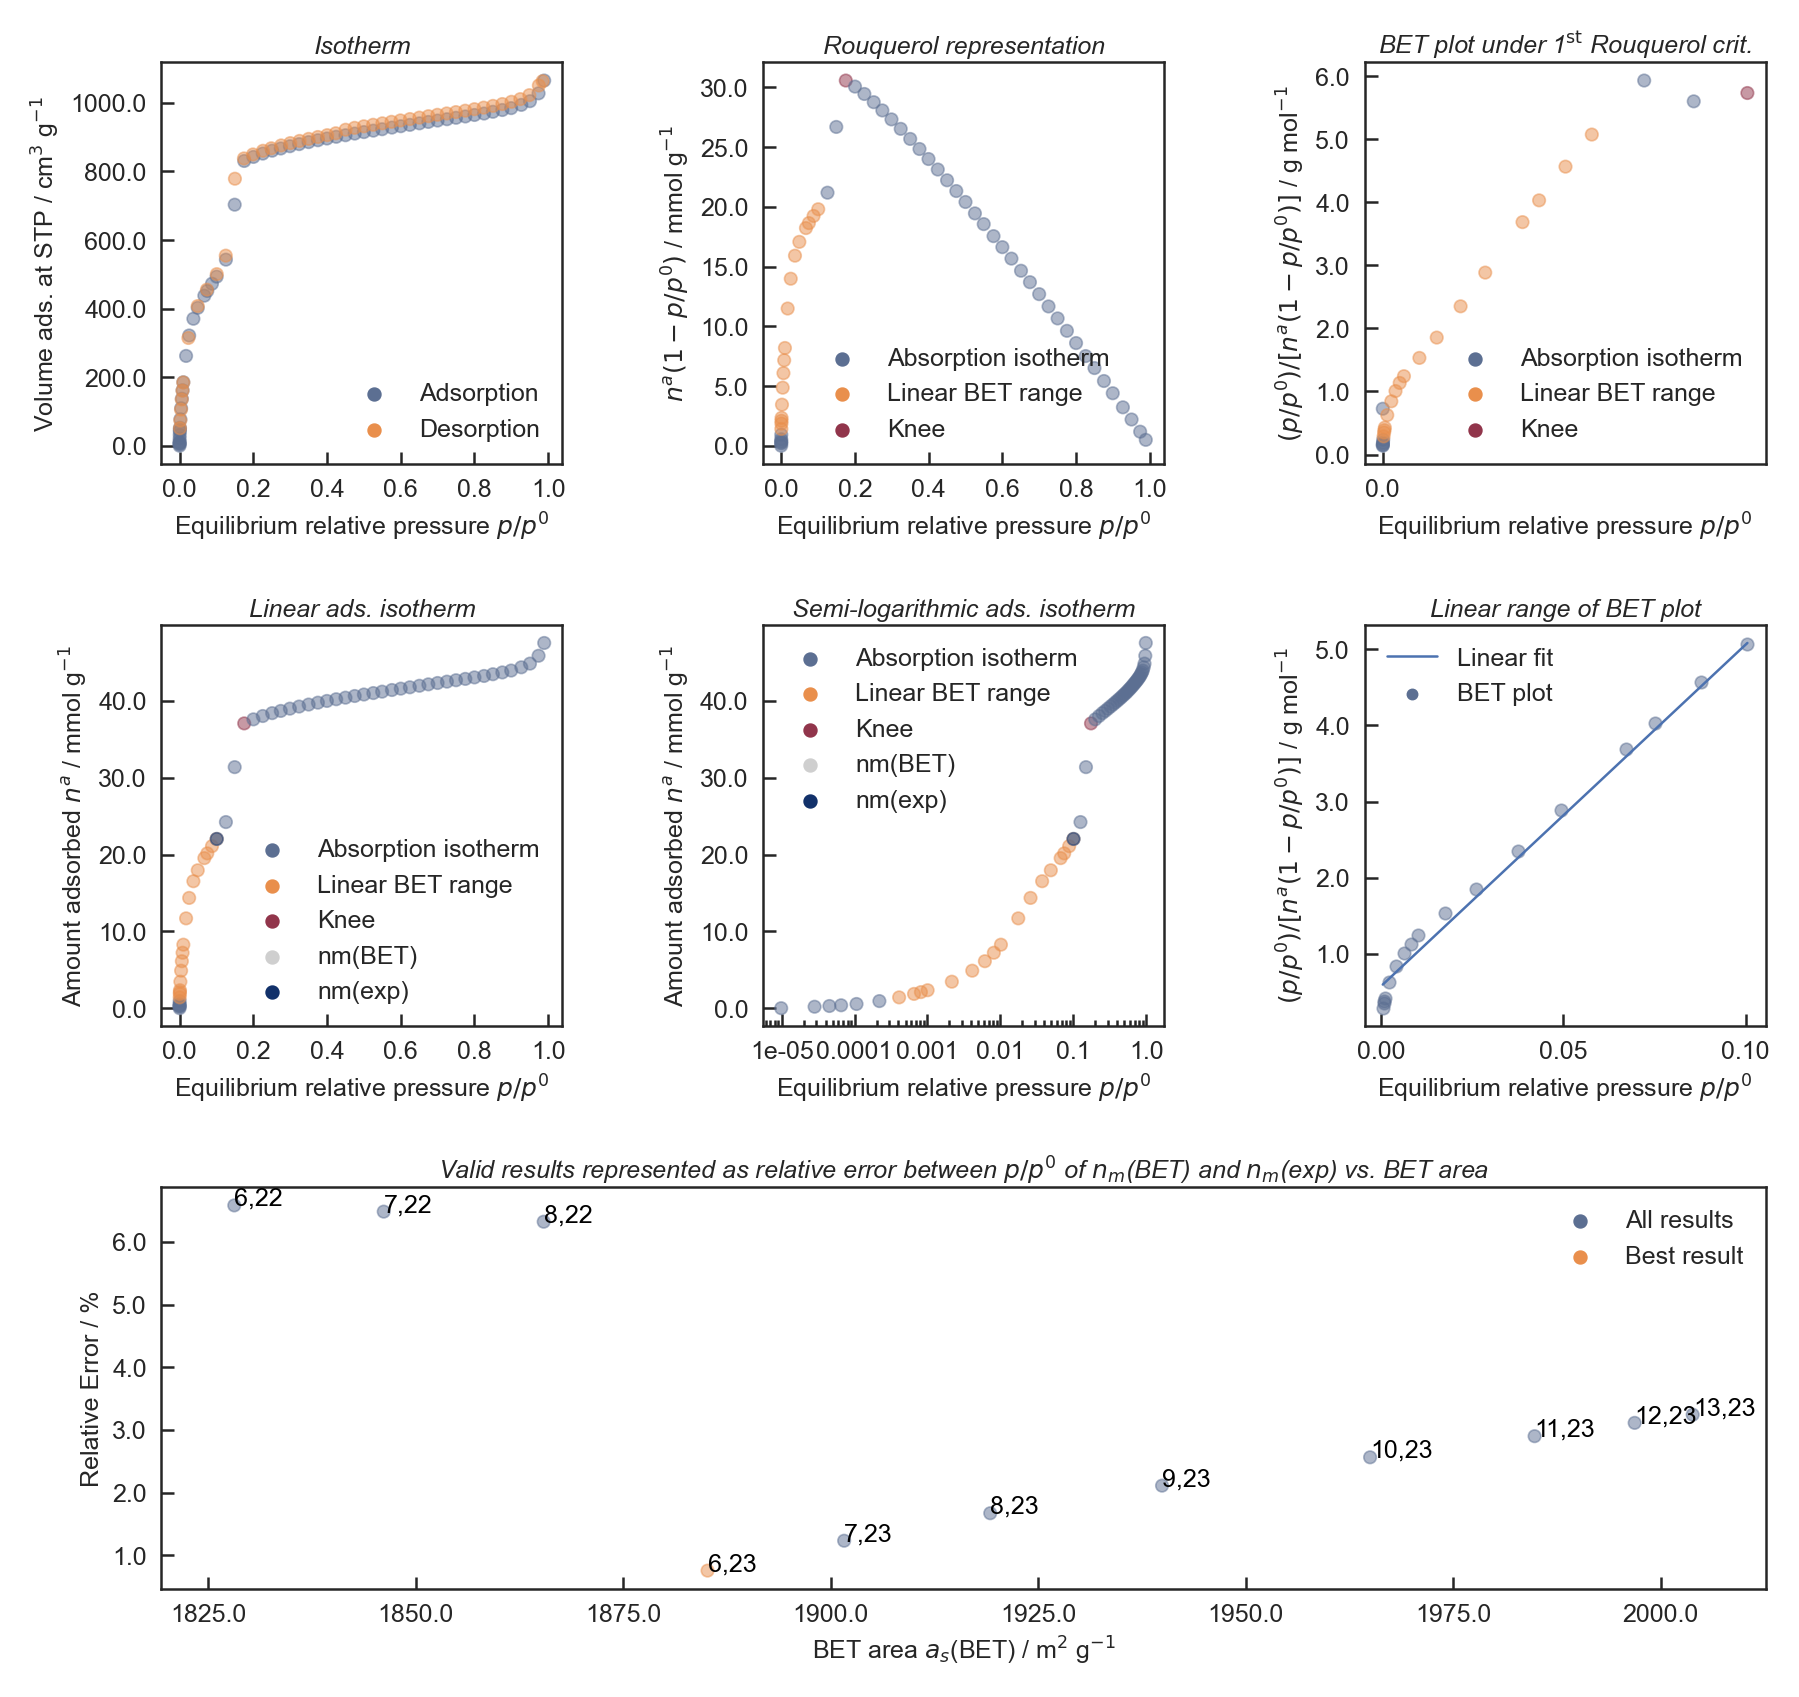

In [255]:
create_figure()